In [6]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.document_loaders.csv_loader import CSVLoader
import pandas as pd

people1 = pd.read_csv('./adas_analysis_pdl_data.csv')



In [8]:
filtered_df = people1[people1['experience'].str.contains('adas', case=False, na=False) |
                      people1['summary'].str.contains('adas', case=False, na=False)]

import ast

def extract_and_concat_summaries(experience):
    if isinstance(experience, str):
        try:
            experience_list = ast.literal_eval(experience)
            summaries = [exp.get('summary') for exp in experience_list if isinstance(exp, dict) and exp.get('summary') is not None]
            return ' '.join(summaries)
        except (ValueError, SyntaxError):
            return ''
    return ''

# Apply the function to the 'experience' column and create a new column 'summaries'
filtered_df['achievements'] = filtered_df['experience'].apply(extract_and_concat_summaries)

filtered_df['summary_achievements'] = 'Overall summary: ' + filtered_df['summary'] + '\n' + 'Achievements: ' + filtered_df['achievements']

/var/folders/r1/_qq3kznd1r5ghs738k7_2xxm0000gq/T/ipykernel_44374/3773930685.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['achievements'] = filtered_df['experience'].apply(extract_and_concat_summaries)
/var/folders/r1/_qq3kznd1r5ghs738k7_2xxm0000gq/T/ipykernel_44374/3773930685.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['summary_achievements'] = 'Overall summary: ' + filtered_df['summary'] + '\n' + 'Achievements: ' + filtered_df['achievements']


In [9]:
len(filtered_df)

522

In [10]:
import openai
import pandas as pd

# Set up your OpenAI API key
openai.api_key = ''

def extract_domain_summary(achievement):
    prompt = f"Given a person's job experience: {achievement}. Can you extract/summarize the domain/product/project this person has worked on? Please make the outputs in concise nouns like autonomous driving system, Medium-Class Excavators. Do not output any extra words"
    response = openai.chat.completions.create(
        model="gpt-4o",  # Specify GPT-4
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=500,
        temperature=0.1
    )
    return response.choices[0].message.content

In [21]:
import os
from openai import OpenAI
OPENAI_API_KEY = ""
openai.OPENAI_API_KEY = OPENAI_API_KEY
os.environ['OPENAI_API_KEY'] = ''
client = OpenAI()

filtered_df.replace('', 'NA', inplace=True)
filtered_df['summary'].fillna('NA', inplace=True)
# Create a new column 'summary_achievements' by concatenating 'summary' and 'achievements' columns
filtered_df['summary_achievements'] = 'Overall summary: ' + filtered_df['summary'] + '\n' + 'Achievements: ' + filtered_df['achievements']
filtered_df = filtered_df[filtered_df['summary_achievements'] != 'Overall summary: NA Achievements: NA']
filtered_df.reset_index(inplace=True)

from langchain_core.output_parsers.string import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

prompt = """Given a person's job experience: \n {achievement}. \n Can you extract/summarize the domain/product/project this person has worked on? Use \n to separate each item and - as the bullet point. 
    The example output is shown below:
            -autonomous driving system
            -Medium-Class Excavators
    Please make the outputs in concise nouns like autonomous driving system, Medium-Class Excavators. Do not output any extra words
            """

prompt = PromptTemplate.from_template(prompt)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

chain = prompt | llm | StrOutputParser()

batch_input = [{"achievement": summary} for summary in filtered_df.summary_achievements]
out = chain.batch(batch_input)

ValueError: cannot insert level_0, already exists

In [22]:
prompt = """Given a person's job experience: \n {achievement}. \n Can you extract/summarize the domain/product/project this person has worked on? Use \n to separate each item and - as the bullet point. 
    The example output is shown below:
            -autonomous driving system
            -Medium-Class Excavators
    Please make the outputs in concise nouns like autonomous driving system, Medium-Class Excavators. Do not output any extra words
            """

prompt = PromptTemplate.from_template(prompt)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

chain = prompt | llm | StrOutputParser()

batch_input = [{"achievement": summary} for summary in filtered_df.summary_achievements]
out = chain.batch(batch_input)

In [23]:
#filtered_df['domain_summary'] = filtered_df['achievements'].apply(extract_domain_summary)
filtered_df['domain_summary'] = out

In [25]:
def split_domain_summary(summary):
    return [item.replace('-', '').replace('*', '').strip() for item in summary.split('\n') if item.strip()]

# 应用此函数到 'domain_summary' 列
filtered_df['domain_list'] = filtered_df['domain_summary'].apply(split_domain_summary)

In [471]:
title_cnt = filtered_df.job_title.value_counts()

filtered_job_counts = title_cnt[title_cnt > 0]
print(filtered_job_counts.to_string())


software engineer                                                                                   24
senior software engineer                                                                            24
system development engineer adas and ad                                                              7
adas test engineer                                                                                   6
system development engineer                                                                          6
senior system engineer                                                                               6
senior software architect                                                                            5
engineering technician                                                                               5
senior test engineer                                                                                 5
senior system development engineer adas and ad                           

In [478]:
filtered_df.columns

Index(['full_name', 'first_name', 'middle_initial', 'middle_name', 'last_name',
       'birth_year', 'birth_date', 'linkedin_url', 'linkedin_username',
       'linkedin_id', 'facebook_url', 'facebook_username', 'facebook_id',
       'twitter_url', 'twitter_username', 'github_url', 'github_username',
       'work_email', 'industry', 'job_title', 'job_title_role',
       'job_title_sub_role', 'job_title_levels', 'job_company_id',
       'job_company_name', 'job_company_website', 'job_company_size',
       'job_company_industry', 'job_company_founded',
       'job_company_linkedin_url', 'job_company_linkedin_id',
       'job_company_facebook_url', 'job_company_location_name',
       'job_company_location_locality', 'job_company_location_region',
       'job_company_location_street_address',
       'job_company_location_address_line_2',
       'job_company_location_postal_code', 'location_name',
       'location_locality', 'location_region', 'location_country',
       'location_continent',

In [480]:
function_concept_counts = filtered_job_counts[filtered_job_counts.index.str.contains('senior', case=False)]

# 计算这些 job_title 出现次数的总和
total_sum = function_concept_counts.sum()

print(f"Sum of job titles containing 'function' and 'concept': {total_sum}")

Sum of job titles containing 'function' and 'concept': 184


In [30]:
import os
from openai import OpenAI
OPENAI_API_KEY = ""
openai.OPENAI_API_KEY = OPENAI_API_KEY
os.environ['OPENAI_API_KEY'] = ''
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   #text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def split_and_get_embedding(text):
    embeddings = [get_embedding(part.strip(), model='text-embedding-3-small') for part in text if part.strip() != '']
    return embeddings


def concat_lists_if_both_are_lists(row):
    if isinstance(row['domain_list'], list) and isinstance(row['skills'], list):
        return row['domain_list'] + row['skills']
    else:
        return row['domain_list']

filtered_df['skills'] = filtered_df['skills'].apply(ast.literal_eval)
# 应用到 DataFrame 中
filtered_df['domain_list'] = filtered_df.apply(concat_lists_if_both_are_lists, axis=1)
# 对 summary_result2 列进行分割和嵌入计算，并存储到新的列 embedding3 中
#filtered_df['embedding'] = filtered_df['domain_list'].apply(split_and_get_embedding)

In [32]:
def get_embedding_from_list(list_text, model="text-embedding-3-small"):
    embeddings = []
    max_length = 2048
    for i in range(0, len(list_text), max_length):
        chunk = list_text[i:i + max_length]
        outs = client.embeddings.create(input=chunk, model=model)
        embeddings.extend([out.embedding for out in outs.data])
    return embeddings

filtered_df['embedding'] = filtered_df['domain_list'].apply(get_embedding_from_list)

In [35]:
skill_exp = pd.read_csv('/Users/yufeng.niu/Documents/skill_exp_combo.csv')

def get_embedding_from_list(list_text, model="text-embedding-3-small"):
    embeddings = []
    max_length = 2048
    for i in range(0, len(list_text), max_length):
        chunk = list_text[i:i + max_length]
        outs = client.embeddings.create(input=chunk, model=model)
        embeddings.extend([out.embedding for out in outs.data])
    return embeddings

skill_exp['embedding'] = get_embedding_from_list(skill_exp.value)

from sklearn.metrics.pairwise import cosine_similarity

def find_similar_skills(row, df2):
    similar_skills = []
    for emb in row['embedding']:
        similarities = cosine_similarity([emb], df2['embedding'].tolist())[0]
        similar_skills.extend(df2.loc[similarities > 0.67, 'value'].tolist())
    return similar_skills

filtered_df['mapped_result'] = filtered_df.apply(lambda row: find_similar_skills(row,skill_exp), axis=1)


KeyboardInterrupt: 

In [38]:
from concurrent.futures import ThreadPoolExecutor

def find_similar_skills(row_embeddings, df2_embeddings, df2_values, threshold=0.67):
    similarities = cosine_similarity(row_embeddings, df2_embeddings)
    similar_indices = np.where(similarities > threshold)
    similar_skills = df2_values.iloc[similar_indices[1]].tolist()
    return similar_skills

def process_row(row, df2_embeddings, df2_values):
    row_embeddings = row[filtered_df.columns.get_loc('embedding')]  # Adjust to get the correct tuple index
    return find_similar_skills(row_embeddings, df2_embeddings, df2_values)

# Precompute embeddings and values from df2
df2_embeddings = np.array(skill_exp['embedding'].tolist())
df2_values = skill_exp['value']

# Parallel processing using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=8) as executor:
    filtered_df['mapped_result'] = list(executor.map(lambda row: process_row(row, df2_embeddings, df2_values), filtered_df.itertuples(index=False)))

# Alternatively, without parallel processing:

In [40]:
filtered_df['mapped_result'] = filtered_df['mapped_result'].apply(lambda x: list(set(x)))

In [67]:
all_values_per_row = [set(sublist) for sublist in filtered_df['mapped_result']]

# Count how many rows each value appears in
value_counts = Counter()
for unique_values in all_values_per_row:
    value_counts.update(unique_values)

# Calculate the percentage of rows each value appears in
total_rows = filtered_df.shape[0]
percentile_appearance = {key: (value_counts[key] / total_rows) * 100 for key in value_counts}

# Sort by frequency and select the top 100
top_100 = value_counts.most_common(200)

# Add percentages to the top 100
top_200_with_percentiles = [(value, count, percentile_appearance[value]) for value, count in top_100]


In [129]:
filtered_df.to_csv('competitor_adas_engineer.csv')

In [55]:


all_domains = [domain for sublist in filtered_df['domain_list'] for domain in sublist]

# 计算每个领域的出现次数
domain_counts = Counter(all_domains)

top_100_domains = domain_counts.most_common(100)

# Convert to DataFrame for easier viewing
top_100_df = pd.DataFrame(top_100_domains, columns=['Domain', 'Count'])

In [62]:
from collections import Counter

all_domains = [domain for sublist in filtered_df['domain_list'] for domain in sublist]

# 计算每个领域的出现次数
domain_counts = Counter(all_domains)

filtered_domain_counts = {domain: count for domain, count in domain_counts.items() if count > 1}

# 生成 GPT 提示
prompt = f"Here is a list of domains that engineers work on: {list(filtered_domain_counts.keys())}. Please summarize the most common and popular domains."

# 使用 GPT API 获取总结
response = openai.chat.completions.create(
  model="gpt-4",
  messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
)

# 输出 GPT 的总结
print(response.choices[0].message.content)

Based on the extensive list provided, here are some of the most common and popular domains in engineering:

1. **Automotive & Autonomous Systems**: This includes autonomous driving systems, Advanced Driver Assistance Systems (ADAS), electric vehicles (EVs), autonomous vehicles, powertrain systems development, and vehicle dynamics among others.

2. **Embedded Systems and Software Engineering**: Many engineers work in developing and managing embedded systems, including firmware development, software integration, software-defined vehicles, and more. 

3. **Programming & Algorithms**: Domains like C++, Python, Java, JavaScript, Matlab are also quite popular for software development, machine learning algorithms, image processing, and data analysis.

4. **Computer Vision and Machine Learning**: These technologies are largely adopted in autonomous systems for object detection, image segmentation, pattern recognition, sensor fusion, and perception systems.

5. **Electrical Engineering**: This 

In [80]:
skill_cate = pd.read_csv('skill_cate.csv')

In [411]:
# Step 1: Explode the `mapped_result` column to have one value per row
exploded_df = filtered_df.explode('mapped_result')

# Step 2: Merge with skill_cate to get the category (cate) for each value in `mapped_result`
market_merged_df = exploded_df.merge(skill_cate, left_on='mapped_result', right_on='value', how='inner')

# Step 3: Group by category and count distinct rows in `filtered_df`
distinct_rows_per_cate = market_merged_df.groupby('cate')['full_name'].nunique()  # Assuming there's an index or unique row identifier

# Print the results
print(distinct_rows_per_cate)

cate
Electronics & Power Systems             105
Embedded Systems                        218
Infotainment System                      35
Machine Learning & AI                   125
Manufacturing & Process Optimization    116
Networking & Communication               34
Robotics & Control Systems              100
Simulation & Modeling                   268
Name: full_name, dtype: int64


In [483]:
simu_ppl = market_merged_df[market_merged_df['cate']=='Simulation & Modeling' ]
simu_ppl1 = filtered_df[filtered_df['linkedin_id'].isin(simu_ppl['linkedin_id'])]

In [89]:
import json

degree_hierarchy = {
    'phd': 4,
    'master\'s': 3,
    'master': 3,
    'bachelor\'s': 2,
    'bachelors': 2,
    'associate\'s': 1,
    'associate': 1
}

# Function to extract the highest degree
def extract_highest_degree(degrees):
    if not degrees:
        return None
    highest_degree = max(degrees, key=lambda degree: degree_hierarchy.get(degree.lower(), 0))
    return highest_degree

# Function to parse JSON and extract highest degree
def get_highest_degree_from_json(json_str):
    # Convert single quotes to double quotes for valid JSON parsing
    json_str = json_str.replace("'", "\"")
    try:
        data_list = json.loads(json_str)
        # Extract degrees from all records
        all_degrees = [degree for record in data_list for degree in record.get('degrees', [])]
        return extract_highest_degree(all_degrees)
    except json.JSONDecodeError:
        return None

# Apply the function to extract the highest degree
filtered_df['highest_degree'] = filtered_df['education'].apply(get_highest_degree_from_json)

In [101]:
filtered_df['education'] = filtered_df['education'].apply(ast.literal_eval)

# Explode the list so each education entry becomes a separate row
education_exploded = filtered_df.explode('education').reset_index(drop=True)

# Normalize the nested JSON structure to flatten it into columns
education_df = pd.json_normalize(education_exploded['education'])

education_df['full_name'] = education_exploded['full_name']


In [103]:
# Convert 'end_date' to numeric (handling cases where 'end_date' might be missing or None)
education_df['end_date'] = pd.to_numeric(education_df['end_date'], errors='coerce')

# Sort by 'full_name' and 'end_date' to get the most recent entry per person
education_df_sorted = education_df.sort_values(by=['full_name', 'end_date'], ascending=[True, False])

# Drop duplicates keeping the most recent entry per person (based on sorted order)
education_most_recent = education_df_sorted.drop_duplicates(subset=['full_name'], keep='first')

# Select only the columns 'degrees', 'school.name', and 'full_name'
education_filtered = education_most_recent[['full_name', 'degrees', 'school.name']]

In [105]:
education_filtered.degrees.value_counts()

[master of science, masters]                                                      141
[]                                                                                 98
[masters]                                                                          89
[bachelors, bachelor of science]                                                   32
[doctorates, doctor of philosophy]                                                 32
[masters, master of engineering]                                                   28
[bachelors]                                                                        25
[bachelor of engineering, bachelors]                                               22
[bachelor of applied science, bachelors]                                           10
[master of business administration, masters]                                       10
[masters, master of science in electrical engineering]                              4
[bachelors, bachelor of technology]                   

In [712]:
bins = [0, 5, 10, 20, float('inf')]
labels = ['<5 years', '5-10 years', '10-20 years', '>20 years']

# Apply pd.cut to bin the 'inferred_years_experience' column
filtered_df['experience_category'] = pd.cut(filtered_df['inferred_years_experience'], bins=bins, labels=labels, right=False)

# Calculate the count of each bin
bin_counts = filtered_df['experience_category'].value_counts()

# Calculate the ratio (percentage) for each bin
total_count = len(filtered_df)
bin_ratios = bin_counts / total_count * 100

# Display the ratio for each bin
print(bin_ratios)

10-20 years    52.873563
5-10 years     33.908046
>20 years       7.854406
<5 years        5.363985
Name: experience_category, dtype: float64


In [211]:
keywords = ['circuit design', 'sensor', 'radar']

# Function to check if any of the keywords are present in skills or summary_achievements
def contains_keywords(row,keywords):
    # Convert list of skills to a single string for easier matching
    skills_str = ' '.join(row['skills']).lower() if isinstance(row['skills'], list) else ''
    summary = row['summary_achievements'].lower() if isinstance(row['summary_achievements'], str) else ''
    
    # Check if any keyword is in the skills or summary
    return any(keyword in skills_str or keyword in summary for keyword in keywords)

# Apply the function to create a new column to indicate whether the person has any of the keywords
filtered_df['has_keywords'] = filtered_df.apply(contains_keywords, axis=1, keywords=keywords)

# Group by job_company_name and calculate the percentage of people with keywords
result = filtered_df.groupby('job_company_name').agg(
    total_people=('has_keywords', 'size'),
    people_with_keywords=('has_keywords', 'sum')
).reset_index()

# Calculate the percentage
result['percentage_with_keywords'] = (result['people_with_keywords'] / result['total_people']) * 100

# Display the result
print(result[['job_company_name', 'percentage_with_keywords']])

   job_company_name  percentage_with_keywords
0            cariad                 31.428571
1            cruise                 53.191489
2  horizon robotics                 46.153846
3           momenta                 33.333333
4          motional                 51.724138
5             tesla                 23.148148
6             waymo                 47.826087
7             wayve                 85.714286
8              zoox                 45.454545


In [117]:
keywords1 = ['autonomous driv', 'vehicle dynamics', 'powertrain']

filtered_df['has_keywords'] = filtered_df.apply(contains_keywords, axis=1, keywords=keywords1)

# Group by job_company_name and calculate the percentage of people with keywords
result = filtered_df.groupby('job_company_name').agg(
    total_people=('has_keywords', 'size'),
    people_with_keywords=('has_keywords', 'sum')
).reset_index()

# Calculate the percentage
result['percentage_with_keywords'] = (result['people_with_keywords'] / result['total_people']) * 100

# Display the result
print(result[['job_company_name', 'percentage_with_keywords']])

   job_company_name  percentage_with_keywords
0            cariad                 20.816327
1            cruise                 40.425532
2  horizon robotics                 30.769231
3           momenta                 33.333333
4          motional                 37.931034
5             tesla                 32.407407
6             waymo                 47.826087
7             wayve                 57.142857
8              zoox                 52.272727


In [118]:
keywords2 = ['object detect', 'perception', 'image segmen','sensor fusion','pattern recog']

filtered_df['has_keywords'] = filtered_df.apply(contains_keywords, axis=1, keywords=keywords2)

# Group by job_company_name and calculate the percentage of people with keywords
result = filtered_df.groupby('job_company_name').agg(
    total_people=('has_keywords', 'size'),
    people_with_keywords=('has_keywords', 'sum')
).reset_index()

# Calculate the percentage
result['percentage_with_keywords'] = (result['people_with_keywords'] / result['total_people']) * 100

# Display the result
print(result[['job_company_name', 'percentage_with_keywords']])

   job_company_name  percentage_with_keywords
0            cariad                 15.918367
1            cruise                 21.276596
2  horizon robotics                 30.769231
3           momenta                 16.666667
4          motional                 27.586207
5             tesla                  4.629630
6             waymo                 30.434783
7             wayve                 28.571429
8              zoox                 27.272727


In [210]:
keywords3 = ['firmware develop', 'fluid mechanic', 'finite element']

filtered_df['has_keywords'] = filtered_df.apply(contains_keywords, axis=1, keywords=keywords3)

# Group by job_company_name and calculate the percentage of people with keywords
result = filtered_df.groupby('job_company_name').agg(
    total_people=('has_keywords', 'size'),
    people_with_keywords=('has_keywords', 'sum')
).reset_index()

# Calculate the percentage
result['percentage_with_keywords'] = (result['people_with_keywords'] / result['total_people']) * 100

# Display the result
print(result[['job_company_name', 'percentage_with_keywords']])

   job_company_name  percentage_with_keywords
0            cariad                  3.265306
1            cruise                  6.382979
2  horizon robotics                  0.000000
3           momenta                  0.000000
4          motional                 17.241379
5             tesla                  8.333333
6             waymo                  4.347826
7             wayve                  0.000000
8              zoox                 11.363636


In [734]:
ml_data_keywords = ['data scien', 'data anal', 'machine lear', 'algorithm']
testing_keywords = ['test', 'validation', 'quality', 'qa']
safety_keywords = ['safety', 'reliability']
function_concept_keywords = ['function and concept']
architect_keywords = ['architect']

embedded_system_related_keywords = [
    "Embedded", "Sensor", "Sensors", "Sensorset", "Electronic Control Units", 
    "Microcontroller", "Microprocessor", "Actuator", "Radar", 
    "LiDAR", "Ultrasonic Sensor", "Camera", "Real-time operating system",
    "Communication Interface", "CAN Bus", "Ethernet", 
    "FlexRay", "Power Management", "control system","ecu","Controller Area Network","rtos"
]

embedded_system_related_keywords = [keyword.lower() for keyword in embedded_system_related_keywords]

# Function to categorize job titles based on keywords
def categorize_job(row):
    job_title = row['job_title'].lower()
    summary_achievements = row['summary_achievements'].lower()  # Join list to string
    skills = ' '.join(row['skills']).lower()  # Join list to string

    # Machine Learning and Data related
    if any(keyword in job_title for keyword in ml_data_keywords):
        return 'Machine Learning & Data'
    
    # Testing & Validation
    elif any(keyword in job_title for keyword in testing_keywords):
        return 'Testing & Validation'
    
    # Safety
    elif any(keyword in job_title for keyword in safety_keywords):
        return 'Functional Safety'
    
    # Function and concept engineer
    elif any(keyword in job_title for keyword in function_concept_keywords):
        return 'Function & concept'
    
    # Systems Architecture related
    elif any(keyword in job_title for keyword in architect_keywords):
        return 'Architecture'
    
    # Embedded System related
    elif any(keyword in summary_achievements for keyword in embedded_system_related_keywords) or \
         any(keyword in skills for keyword in embedded_system_related_keywords):
        return 'Embedded System'
    
    # General Software Engineer (default)
    else:
        return 'General Software Dev'

# Apply the function to create the new column
filtered_df['job_cate'] = filtered_df.apply(categorize_job, axis=1)

In [664]:
def categorize_job_level(job_title):
    job_title = job_title.lower()
    if 'manager' in job_title:
        return 'L9'
    elif 'tech lead' in job_title:
        return 'L9'
    elif 'senior staff' in job_title:
        return 'L7'
    elif 'staff' in job_title:
        return 'L6'
    elif 'principal' in job_title:
        return 'L8'
    elif 'senior' in job_title:
        return 'L5'
    else:
        return 'Other'

# Apply the functions to create new columns

filtered_df['job_level'] = filtered_df['job_title'].apply(categorize_job_level)

In [666]:
def categorize_job_level2(job_level):
    #job_level = job_level.lower()
    if job_level == 'L5' or job_level =='L6':
        return 'L5-6'
    elif job_level == 'L7' or job_level =='L8':
        return 'L7-8'
    elif job_level == 'Other':
        return 'General'
    else:
        return 'L9'

# Apply the functions to create new columns

filtered_df['job_level2'] = filtered_df['job_level'].apply(categorize_job_level2)

In [700]:
exploded_df = filtered_df.explode('mapped_result')

# Step 2: Merge with `skill_cate` to get the category (cate) for each value in `mapped_result`
market_merged_df = exploded_df.merge(skill_cate, left_on='mapped_result', right_on='value', how='inner')

# Step 3: Group by both `job_cate` and `cate` to count distinct rows (full_name)
distinct_rows_per_cate_job_cate = market_merged_df.groupby(['job_cate', 'cate'])['full_name'].nunique().reset_index()

# Step 4: Calculate total number of distinct people in each `job_cate`
total_people_per_job_cate = market_merged_df.groupby('job_cate')['full_name'].nunique().reset_index()
total_people_per_job_cate = total_people_per_job_cate.rename(columns={'full_name': 'total_people'})

# Step 5: Merge the distinct count with the total people count
merged_distinct_total = distinct_rows_per_cate_job_cate.merge(total_people_per_job_cate, on='job_cate', how='left')

# Step 6: Calculate percentage of distinct people per `cate` within each `job_cate`
merged_distinct_total['percentage'] = (merged_distinct_total['full_name'] / merged_distinct_total['total_people']) * 100

# Final result: merged_distinct_total contains job_cate, cate, distinct full_name counts, total people, and percentage
print(merged_distinct_total)

                             job_cate                                  cate  \
0             Embedded System related           Electronics & Power Systems   
1             Embedded System related                      Embedded Systems   
2             Embedded System related                   Infotainment System   
3             Embedded System related                 Machine Learning & AI   
4             Embedded System related  Manufacturing & Process Optimization   
5             Embedded System related            Networking & Communication   
6             Embedded System related            Robotics & Control Systems   
7             Embedded System related                 Simulation & Modeling   
8       Function and concept engineer           Electronics & Power Systems   
9       Function and concept engineer                      Embedded Systems   
10      Function and concept engineer                   Infotainment System   
11      Function and concept engineer               

In [701]:
merged_distinct_total.to_csv('job_cate_skill_cate_cross.csv')

In [497]:
job_level_counts = filtered_df.groupby(['job_cate', 'job_level']).size().reset_index(name='count')

# Step 2: Calculate the total number of people for each `job_cate`
total_people_per_job_cate = filtered_df.groupby('job_cate').size().reset_index(name='total_count')

# Step 3: Merge the count of `job_level` with the total number of people in each `job_cate`
merged_job_level = job_level_counts.merge(total_people_per_job_cate, on='job_cate')

# Step 4: Calculate the percentage of each `job_level` within each `job_cate`
merged_job_level['percentage'] = (merged_job_level['count'] / merged_job_level['total_count']) * 100

# Final result: merged_job_level contains job_cate, job_level, counts, total people, and percentage
print(merged_job_level)

                             job_cate  job_level  count  total_count  \
0             Embedded System related    General    140          259   
1             Embedded System related  Principal      9          259   
2             Embedded System related     Senior    101          259   
3             Embedded System related      Staff      9          259   
4       Function and concept engineer    General     10           16   
5       Function and concept engineer     Senior      6           16   
6           General Software Engineer    General     79          112   
7           General Software Engineer     Senior     31          112   
8           General Software Engineer      Staff      2          112   
9   Machine Learning and Data related    General     14           24   
10  Machine Learning and Data related     Senior     10           24   
11                             Safety    General      7           18   
12                             Safety  Principal      1         

In [668]:
job_level_counts = filtered_df.groupby(['job_cate', 'job_level2']).size().reset_index(name='count')

# Step 2: Calculate the total number of people for each `job_cate`
total_people_per_job_cate = filtered_df.groupby('job_cate').size().reset_index(name='total_count')

# Step 3: Merge the count of `job_level` with the total number of people in each `job_cate`
merged_job_level = job_level_counts.merge(total_people_per_job_cate, on='job_cate')

# Step 4: Calculate the percentage of each `job_level` within each `job_cate`
merged_job_level['percentage'] = (merged_job_level['count'] / merged_job_level['total_count']) * 100

# Final result: merged_job_level contains job_cate, job_level, counts, total people, and percentage
print(merged_job_level)

                             job_cate job_level2  count  total_count  \
0             Embedded System related    General    130          259   
1             Embedded System related       L5-6     99          259   
2             Embedded System related       L7-8     12          259   
3             Embedded System related         L9     18          259   
4       Function and concept engineer    General     10           16   
5       Function and concept engineer       L5-6      6           16   
6           General Software Engineer    General     78          112   
7           General Software Engineer       L5-6     29          112   
8           General Software Engineer         L9      5          112   
9   Machine Learning and Data related    General     14           24   
10  Machine Learning and Data related       L5-6      8           24   
11  Machine Learning and Data related         L9      2           24   
12                             Safety    General      6         

In [669]:
merged_job_level.to_csv('job_cate_level_analysis.csv')

In [671]:
exploded_df = filtered_df.explode('mapped_result')

# Step 2: Merge with skill_cate to get the category (cate) for each value in `mapped_result`
market_merged_df = exploded_df.merge(skill_cate, left_on='mapped_result', right_on='value', how='inner')

In [674]:
unique_counts = market_merged_df.groupby(['job_cate', 'job_level2', 'full_name'])['mapped_result'].nunique().reset_index(name='unique_mapped_count')

# Step 2: Calculate the average unique count for each combination of 'job_cate' and 'job_level2'
average_unique_counts = unique_counts.groupby(['job_cate', 'job_level2'])['unique_mapped_count'].mean().reset_index(name='average_unique_mapped_count')

# Display the result
print(average_unique_counts)
average_unique_counts.to_csv('average_core_skill.csv')


                             job_cate job_level2  average_unique_mapped_count
0             Embedded System related    General                     5.807339
1             Embedded System related       L5-6                     6.325843
2             Embedded System related       L7-8                     7.454545
3             Embedded System related         L9                     6.312500
4       Function and concept engineer    General                     3.857143
5       Function and concept engineer       L5-6                     7.200000
6           General Software Engineer    General                     3.595238
7           General Software Engineer       L5-6                     3.800000
8           General Software Engineer         L9                    10.000000
9   Machine Learning and Data related    General                     4.454545
10  Machine Learning and Data related       L5-6                     5.000000
11  Machine Learning and Data related         L9                

In [709]:
item_counts = exploded_df.groupby(['job_cate', 'mapped_result'])['full_name'].nunique().reset_index(name='count')

# Step 3: Find the most frequent items for each `job_cate`
# Sort by `job_cate` and `count` (descending), then keep only the top item for each `job_cate`
most_frequent_items = item_counts.sort_values(['job_cate', 'count'], ascending=[True, False])
total_user_counts = exploded_df.groupby('job_cate')['full_name'].nunique().reset_index(name='total_user_count')
merged_counts = pd.merge(most_frequent_items, total_user_counts, on='job_cate')
merged_counts['percentage'] = merged_counts['count'] / merged_counts['total_user_count']
# Optionally: You can keep the top N items for each job_cate using the following code
top_n_items_per_cate = merged_counts.groupby('job_cate').head(30)  # Change `1` to `N` for top N

# Output the result
print(top_n_items_per_cate)
top_n_items_per_cate.to_csv('market_job_cate_skills.csv')


                     job_cate                       mapped_result  count  \
0     Embedded System related                                ADAS    141   
1     Embedded System related                              MATLAB    136   
2     Embedded System related          Autonomous Driving Systems    135   
3     Embedded System related                                 C++    133   
4     Embedded System related  Advanced Driver Assistance Systems    113   
...                       ...                                 ...    ...   
1886     Testing & Validation                            Autodesk     13   
1887     Testing & Validation       Embedded System Configuration     13   
1888     Testing & Validation                    Integration Test     12   
1889     Testing & Validation                             LabVIEW     12   
1890     Testing & Validation           Ansys Simulation Software     11   

      total_user_count  percentage  
0                  259    0.544402  
1            

company pie chart

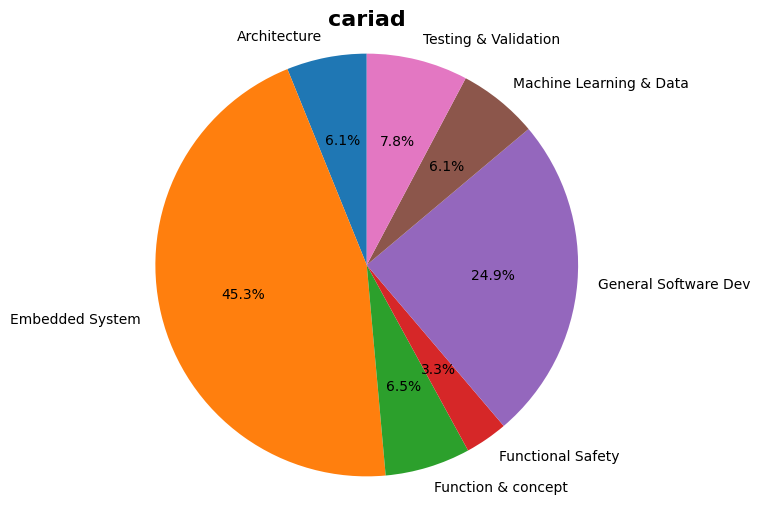

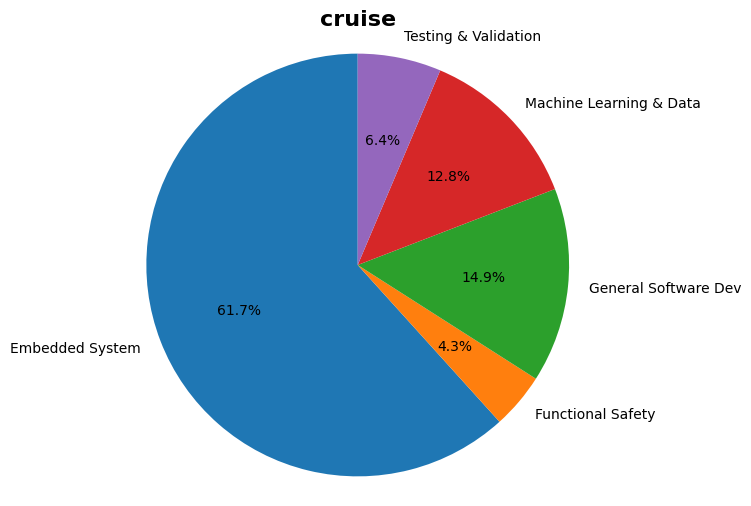

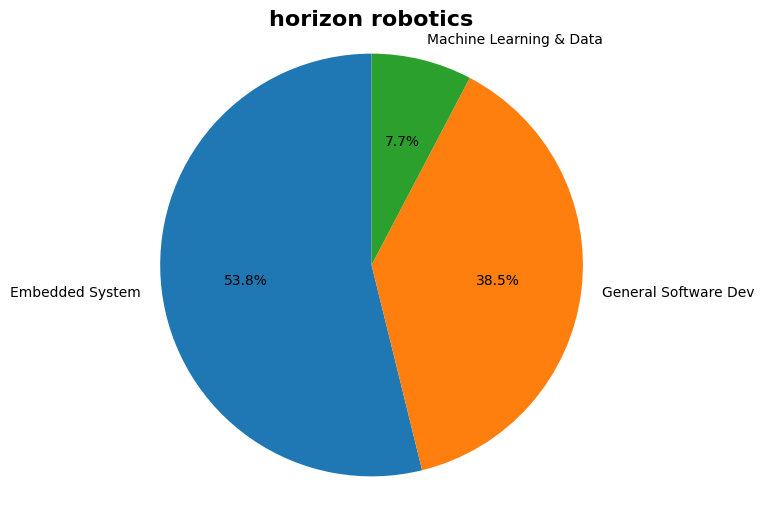

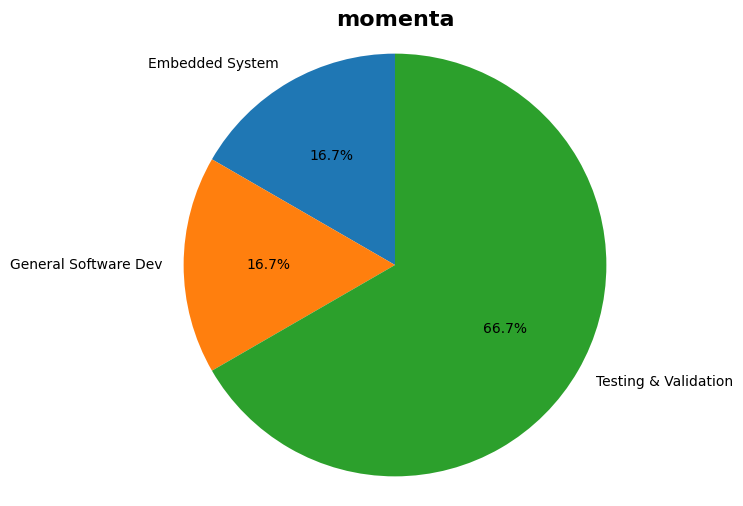

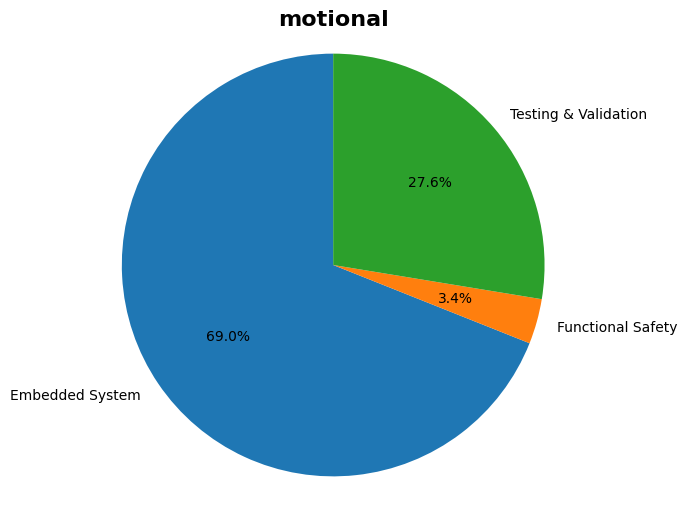

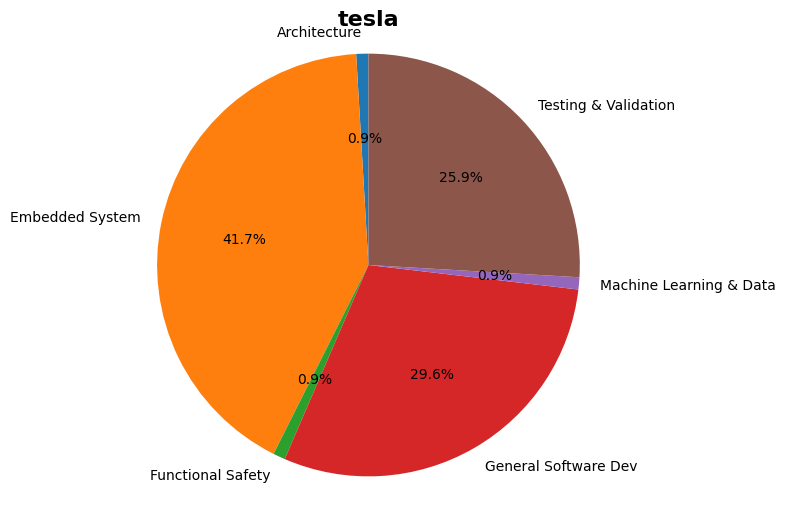

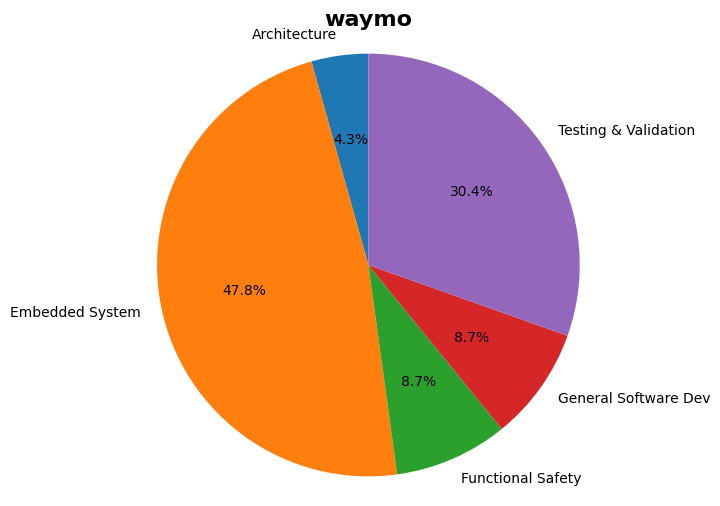

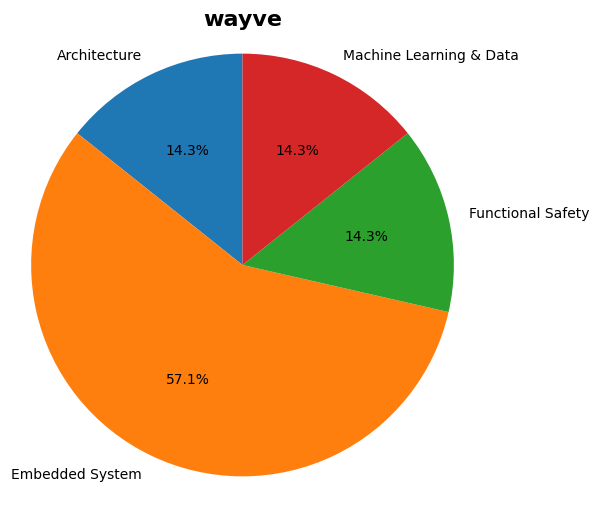

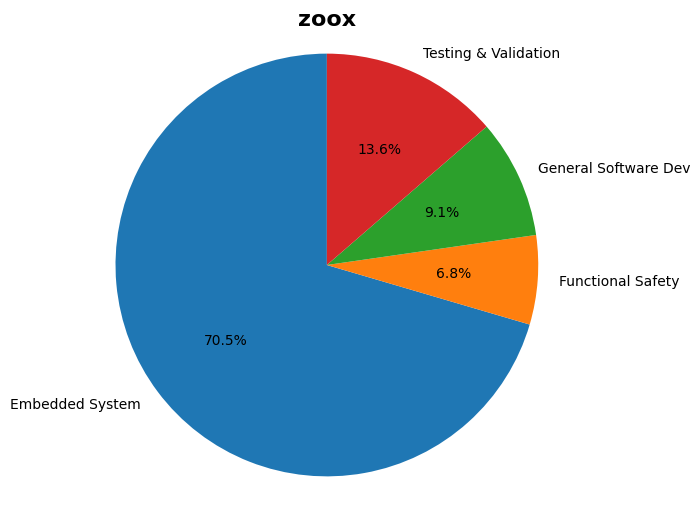

In [735]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Group the data by 'job_company_name' and 'job_cate' to get the counts
job_cate_counts = filtered_df.groupby(['job_company_name', 'job_cate']).size().reset_index(name='count')

# Step 2: Calculate the total count per company to get percentages
job_cate_counts['total_count'] = job_cate_counts.groupby('job_company_name')['count'].transform('sum')
job_cate_counts['percentage'] = (job_cate_counts['count'] / job_cate_counts['total_count']) * 100

# Step 3: Plot pie charts for each job_company_name
companies = job_cate_counts['job_company_name'].unique()

for company in companies:
    company_data = job_cate_counts[job_cate_counts['job_company_name'] == company]
    
    plt.figure(figsize=(6, 6))
    plt.pie(company_data['percentage'], labels=company_data['job_cate'], autopct='%1.1f%%', startangle=90)
    plt.title(f'{company}', fontsize=16, fontweight='bold')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


In [732]:
job_cate_counts.to_csv('company_pie_data.csv')

In [558]:
top_n_items_per_cate.to_csv('job_cate_skills.csv')

woven analysis starts here

In [572]:
skill = pd.read_csv('skills-2.csv')
achievement = pd.read_csv('achievements-2.csv')

In [431]:
role = pd.read_csv('prod_roles_0917.csv')

In [574]:
role_2 = pd.read_csv('roles-2.csv')

In [580]:
occupation_group = pd.read_csv('occupation_group.csv')

In [582]:
role_2 = role_2.merge(occupation_group, left_on='occupation', right_on='occupation_name', how='left')

occupation analysis


In [585]:
#role = pd.read_csv('prod_roles.csv')
final_id = pd.read_csv('target_employees-2.csv')
#role['profile_created_at'] = pd.to_datetime(role['profile_created_at'])




# 应用过滤条件
#filtered_role = role[company_filter]
filtered_role = role_2[role_2['anon_user_id'].isin(final_id['anon_user_id'])]

In [587]:
occupation_counts = filtered_role['occupation'].value_counts()

# 将结果转换为 DataFrame
filtered_role = occupation_counts.reset_index()

# 重命名列名
filtered_role.columns = ['occupation', 'count']

filtered_role.to_csv('role_distribution.csv')

In [589]:


skill_1 = skill[skill['skill_master_id'].notna()]
unique_skill = skill_1[['anon_user_id', 'skill']].drop_duplicates()
unique_skill = unique_skill.rename(columns={'skill': 'value'})

# Assuming 'created_by' and 'achievement' columns exist in the 'achievement' DataFrame
achievement_1 = achievement[achievement['experience_master_id'].notna()]
unique_achievement = achievement_1[['anon_user_id', 'achievement']].drop_duplicates()
unique_achievement = unique_achievement.rename(columns={'achievement': 'value'})

# Concatenate the results
concatenated_df = pd.concat([unique_skill, unique_achievement], ignore_index=True)

#filtered_role = role_2[role_2['anon_user_id'].isin(final_id['anon_user_id'])]
filtered_concatenated_df = concatenated_df[concatenated_df['anon_user_id'].isin(final_id['anon_user_id'])]

In [608]:
skill_cate = pd.read_csv('skill_cate.csv')

merged_df = pd.merge(filtered_concatenated_df, skill_cate, left_on='value', right_on='value', how='left')

# Group by 'cate' and count unique 'created_by'
result = merged_df.groupby('cate')['anon_user_id'].nunique().reset_index()

# Rename the column for clarity
result = result.rename(columns={'anon_user_id': 'unique_people_count'})

result.to_csv('cate_distribution.csv')

print(result)

                                   cate  unique_people_count
0           Electronics & Power Systems                   26
1                      Embedded Systems                  117
2                   Infotainment System                    2
3                 Machine Learning & AI                  115
4  Manufacturing & Process Optimization                   48
5            Robotics & Control Systems                   28
6                 Simulation & Modeling                   52


In [609]:
merged_df = merged_df.merge(role_2[['anon_user_id', 'occupation_name', 'occupation_group_name']], 
                                  on='anon_user_id', how='left')

merged_df = pd.merge(merged_df, final_id, on='anon_user_id', how='inner')

In [611]:
occupation_mapping = {
    'Software QA Engineer / Tester': 'Testing & Validation',
    'QA Manager': 'Testing & Validation',
    'Validation Engineer': 'Testing & Validation',
    'Embedded Systems Engineers': 'Embedded System related',
    'Software Architect': 'Systems Architecture related',
    'Systems Architect': 'Systems Architecture related',
    'Machine Learning Engineers': 'Machine Learning and Data related',
    'Data Scientist': 'Machine Learning and Data related'
}

# Apply the mapping to the 'occupation_name' column to create a new column 'job_cate'
merged_df['job_cate'] = merged_df['occupation_name'].map(occupation_mapping)

# If there are occupation names that don't match the mapping, you can handle them by filling with 'Unknown' or another category
merged_df['job_cate'] = merged_df['job_cate'].fillna('other')



In [619]:
location_to_country = {
    'Nihonbashi (Head Office)': 'Japan',
    'Palo Alto': 'USA',
    'Ann Arbor': 'USA',
    'London': 'United Kingdom',
    'Sunnyvale': 'USA',
    'Remote California': 'USA',
    'Remote United Kingdom': 'United Kingdom',
    'Mountain View': 'USA',
    'Remote Massachusetts': 'USA',
    'Higashifuji': 'Japan',
    'Remote Japan': 'Japan',
    'Seattle': 'USA',
    'Remote New York': 'USA',
    'Remote Oregon': 'USA',
    'Remote Washington': 'USA',
    'Brooklyn': 'USA',
    'Remote Colorado': 'USA',
    'Toyota Higashifuji': 'Japan',
    'Remote Illinois': 'USA',
    'Remote New Jersey': 'USA',
    'Remote Utah': 'USA',
    'Remote North Carolina': 'USA',
    'Remote Maryland': 'USA',
    'Remote Texas': 'USA',
    'Remote Nevada': 'USA'
}

# Assuming your DataFrame is called df and has a 'location' column
merged_df['country'] = merged_df['location'].map(location_to_country)

In [623]:
cate_user_counts = merged_df.groupby(['country', 'cate'])['anon_user_id'].nunique().reset_index(name='cate_user_count')

# Calculate the total unique count of users under each job_cate
total_user_counts = merged_df.groupby('country')['anon_user_id'].nunique().reset_index(name='total_user_count')

# Merge the two dataframes to calculate the percentage
merged_counts = pd.merge(cate_user_counts, total_user_counts, on='country')

# Calculate the percentage of users in each cate under each job_cate
merged_counts['percentage'] = merged_counts['cate_user_count'] / merged_counts['total_user_count']

# Display the final result
print(merged_counts[['country', 'cate', 'cate_user_count', 'total_user_count', 'percentage']])

merged_counts.to_csv('woven_country_skill_cate.csv')


           country                                  cate  cate_user_count  \
0            Japan           Electronics & Power Systems               11   
1            Japan                      Embedded Systems               76   
2            Japan                 Machine Learning & AI               50   
3            Japan  Manufacturing & Process Optimization               19   
4            Japan            Robotics & Control Systems               10   
5            Japan                 Simulation & Modeling               31   
6              USA           Electronics & Power Systems               15   
7              USA                      Embedded Systems               38   
8              USA                   Infotainment System                1   
9              USA                 Machine Learning & AI               53   
10             USA  Manufacturing & Process Optimization               27   
11             USA            Robotics & Control Systems               18   

In [626]:
cate_user_counts = merged_df.groupby(['employee_type', 'cate'])['anon_user_id'].nunique().reset_index(name='cate_user_count')

# Calculate the total unique count of users under each job_cate
total_user_counts = merged_df.groupby('employee_type')['anon_user_id'].nunique().reset_index(name='total_user_count')

# Merge the two dataframes to calculate the percentage
merged_counts = pd.merge(cate_user_counts, total_user_counts, on='employee_type')

# Calculate the percentage of users in each cate under each job_cate
merged_counts['percentage'] = merged_counts['cate_user_count'] / merged_counts['total_user_count']

# Display the final result
print(merged_counts[['employee_type', 'cate', 'cate_user_count', 'total_user_count', 'percentage']])

merged_counts.to_csv('woven_employee_type_skill_cate.csv')

          employee_type                                  cate  \
0             Full Time           Electronics & Power Systems   
1             Full Time                      Embedded Systems   
2             Full Time                   Infotainment System   
3             Full Time                 Machine Learning & AI   
4             Full Time  Manufacturing & Process Optimization   
5             Full Time            Robotics & Control Systems   
6             Full Time                 Simulation & Modeling   
7              Secondee           Electronics & Power Systems   
8              Secondee                      Embedded Systems   
9              Secondee                 Machine Learning & AI   
10             Secondee  Manufacturing & Process Optimization   
11             Secondee            Robotics & Control Systems   
12             Secondee                 Simulation & Modeling   
13  Secondee Concurrent                      Embedded Systems   
14    Secondee Outbound  

In [639]:
cate_user_counts = merged_df.groupby(['employee_type', 'value'])['anon_user_id'].nunique().reset_index(name='cate_user_count')

# Step 2: Calculate total unique user counts for each employee_type
total_user_counts = merged_df.groupby('employee_type')['anon_user_id'].nunique().reset_index(name='total_user_count')

# Step 3: Merge the two DataFrames to calculate the percentage
merged_counts = pd.merge(cate_user_counts, total_user_counts, on='employee_type')

# Step 4: Calculate the percentage of unique users for each value
merged_counts['percentage'] = (merged_counts['cate_user_count'] / merged_counts['total_user_count']) * 100

# Step 5: Sort the DataFrame and get the top 20 values for each employee_type based on unique user count
top_20 = merged_counts.sort_values(by='cate_user_count', ascending=False).groupby('employee_type').head(20)

# Display the result
print(top_20)
top_20.to_csv('woven_employee_type_top_skill.csv')

    employee_type                           value  cate_user_count  \
428     Full Time                          Python              150   
492     Full Time            Software Development              141   
83      Full Time                             C++              126   
230     Full Time                             Git              112   
37      Full Time               Agile Methodology              107   
..            ...                             ...              ...   
5      Fixed Term              Strategic Research                1   
4      Fixed Term                Product Strategy                1   
3      Fixed Term              Information Design                1   
2      Fixed Term              Design Prototyping                1   
1      Fixed Term  Cross-Functional Collaboration                1   

     total_user_count  percentage  
428               312   48.076923  
492               312   45.192308  
83                312   40.384615  
230            

In [640]:
skill_df = pd.merge(skill_1, final_id, on='anon_user_id', how='inner')

In [642]:
skill_df['country'] = skill_df['location'].map(location_to_country)

In [645]:
unique_counts = skill_df.groupby(['country', 'skill'])['anon_user_id'].nunique().reset_index(name='unique_user_count')

# Step 2: Filter for skills with more than 5 unique anon_user_id
filtered_skills = unique_counts[unique_counts['unique_user_count'] > 5]

# Step 3: Calculate the average skill_level for these filtered skills
average_skill_levels = skill_df.groupby(['country', 'skill'])['skill_level'].mean().reset_index(name='average_skill_level')

# Step 4: Merge to get the average skill level for filtered skills
merged = pd.merge(filtered_skills, average_skill_levels, on=['country', 'skill'])

# Step 5: Sort and select the top 20 skills for each country based on average skill level
top_skills = merged.sort_values(by=['country', 'average_skill_level'], ascending=[True, False])
top_20_per_country = top_skills.groupby('country').head(20)

# Display the result
print(top_20_per_country)

top_20_per_country.to_csv('top_20_per_country.csv')

            country                                              skill  \
43            Japan                       Product Lifecycle Management   
72            Japan                                      Visual Design   
4             Japan                         Artificial Neural Networks   
10            Japan                          C# (Programming Language)   
31            Japan                                 Interaction Design   
66            Japan                                       Unity Engine   
15            Japan                     Cross-Functional Collaboration   
7             Japan                                   Business Process   
30            Japan                                 Information Design   
54            Japan                                           Simulink   
74            Japan                                Workflow Management   
61            Japan                     Systems Development Life Cycle   
8             Japan                   

In [696]:
unique_counts = skill_df.groupby(['employee_type', 'skill'])['anon_user_id'].nunique().reset_index(name='unique_user_count')

# Step 2: Filter for skills with more than 5 unique anon_user_id
filtered_skills = unique_counts[unique_counts['unique_user_count'] > 5]

# Step 3: Calculate the average skill_level for these filtered skills
average_skill_levels = skill_df.groupby(['employee_type', 'skill'])['skill_level'].mean().reset_index(name='average_skill_level')

# Step 4: Merge to get the average skill level for filtered skills
merged = pd.merge(filtered_skills, average_skill_levels, on=['employee_type', 'skill'])

# Step 5: Sort and select the top 20 skills for each country based on average skill level
top_skills = merged.sort_values(by=['employee_type', 'average_skill_level'], ascending=[True, False])
top_20_per_country = top_skills.groupby('employee_type').head(20)

# Display the result
print(top_20_per_country)

top_20_per_country.to_csv('top_20_per_employ_type.csv')

    employee_type                                              skill  \
30      Full Time                                         Hand Tools   
61      Full Time  SLAM Algorithms (Simultaneous Localization And...   
4       Full Time                         Artificial Neural Networks   
24      Full Time                                  Electrical Wiring   
64      Full Time                                    Software Design   
22      Full Time                                 Design Prototyping   
16      Full Time                     Cross-Functional Collaboration   
33      Full Time                                 Interaction Design   
15      Full Time                                     Control Theory   
31      Full Time                              Human-Centered Design   
70      Full Time                               Systems Architecture   
47      Full Time                               Power Tool Operation   
32      Full Time                                  Image Recogni

In [530]:
max_experience = achievement_1.groupby('created_by')['year_of_experiences'].max().reset_index()

# Step 2: Filter for max year_of_experiences >= 5
filtered_experience = max_experience[max_experience['year_of_experiences'] >= 5]

# Step 3: Get the unique list of 'created_by'
unique_created_by = filtered_experience['created_by'].unique()

,company_name,created_by,global_profile_id,impact,job_title,occupation,occupation_master_id,profile_created_at,role_created_at,role_end_date,role_start_date
0,Woven by Toyota,b8d18942e5c26f4a2163ddae98f96c0a,16cd8fb3-8bfc-4655-bf97-165103564fea,NaN,Executive Assistant,Business Intelligence Analyst,afd64331-9dd4-4705-9dea-d3efe9d400db,2024-09-13T14:55:25.687298Z,2024-09-13T14:56:06.786884Z,NaN,2022-08-01T07:00:00Z
1,Woven by Toyota,05d06784cf8039974f8d13e165001b6b,9ddab449-fd66-4618-9a60-035aef8454d7,NaN,Executive Business Partner,Business Intelligence Analyst,afd64331-9dd4-4705-9dea-d3efe9d400db,2024-09-14T03:18:31.207815Z,2024-09-14T03:20:26.422443Z,NaN,2022-05-01T04:00:00Z
2,Woven by Toyota,08ebe4f7f1d067c443112270f5f846b0,88193fba-dedc-40cc-94e2-ddc268399f7b,NaN,Asst. Manager,Business Intelligence Analyst,afd64331-9dd4-4705-9dea-d3efe9d400db,2024-09-09T23:49:25.965856Z,2024-09-13T01:31:24.651761Z,NaN,2022-06-01T07:00:00Z
3,Woven by Toyota,977c2d24ca8f185f78b058045e10c3c5,f91a9c2c-22b0-477b-85fc-617726548038,NaN,NaN,Business Intelligence Analyst,afd64331-9dd4-4705-9dea-d3efe9d400db,2024-09-12T16:14:20.835196Z,2024-09-12T17:15:50.46811Z,NaN,2021-12-01T05:00:00Z
4,Woven by Toyota,027d26795f3e818e1dc50aea5590fde4,16cd1f78-e025-4e12-a138-7f96f987f450,NaN,Executive Business Partner,Business Intelligence Analyst,afd64331-9dd4-4705-9dea-d3efe9d400db,2024-09-10T02:11:21.422914Z,2024-09-10T02:15:29.492577Z,NaN,2022-05-01T07:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...
996,Woven by Toyota,63f90f2b4422e7d0e0ce8396e4bca53c,2b884012-78e3-48d1-9aa1-90aafe9b1715,NaN,Head of Driverless e-Palette (MaaS),Product Owner,8982df31-1638-48e5-8dad-7d051280289c,2024-09-05T02:42:19.970152Z,2024-09-05T02:54:05.793782Z,NaN,2019-08-31T15:00:00Z
998,Woven by Toyota,80d6b7686db819eaa56c50ed656b9da1,f08d22fa-4802-4822-b434-815de57c6751,BEV Step 3 AD/TMのCloud地図サービスの開発フローをデザインした。,Staff Engineer,Product Owner,8982df31-1638-48e5-8dad-7d051280289c,2024-09-09T01:24:55.723016Z,2024-09-09T01:38:13.813673Z,NaN,2022-12-31T15:00:00Z
999,Woven by Toyota,bb3151fc17f9636cf48c09b71fd925f3,3d61ab2f-aa39-45d6-87b3-8c0f3349c5ee,NaN,NaN,Scrum Master,753d2cc6-16d4-45c3-b7e5-cf92de6938f6,2024-09-13T05:55:51.956773Z,2024-09-13T05:58:20.36201Z,NaN,2018-03-31T15:00:00Z
1005,Woven by Toyota,9292a0e1bba1fb4dee82449ffe89586b,a6e0779e-d125-4099-8e36-6409580139e7,NaN,Controls Engineer,Robotics Engineer,11e13018-ac45-4535-80b8-2c2555bac6d0,2024-09-10T15:13:33.193331Z,2024-09-10T15:15:33.066595Z,NaN,2020-04-01T07:00:00Z


In [436]:
skill_created_by_counts = skill_1.groupby('skill')['created_by'].nunique()

# Count how many skills have more than 5 unique 'created_by'
skills_with_more_than_5_created_by = (skill_created_by_counts > 5).sum()

print(skills_with_more_than_5_created_by)

147


In [437]:
skill_created_by_counts = achievement_1.groupby('achievement')['created_by'].nunique()

# Count how many skills have more than 5 unique 'created_by'
skills_with_more_than_5_created_by = (skill_created_by_counts > 5).sum()

print(skills_with_more_than_5_created_by)

117


/var/folders/r1/_qq3kznd1r5ghs738k7_2xxm0000gq/T/ipykernel_44374/2511887839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_concatenated_df['value'] = filtered_concatenated_df['value'].replace('Agile Methodology', 'Agile Software Development')
/var/folders/r1/_qq3kznd1r5ghs738k7_2xxm0000gq/T/ipykernel_44374/2511887839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_concatenated_df['value'] = filtered_concatenated_df['value'].replace('CI/CD Pipelines', 'CI/CD')
/var/folders/r1/_qq3k

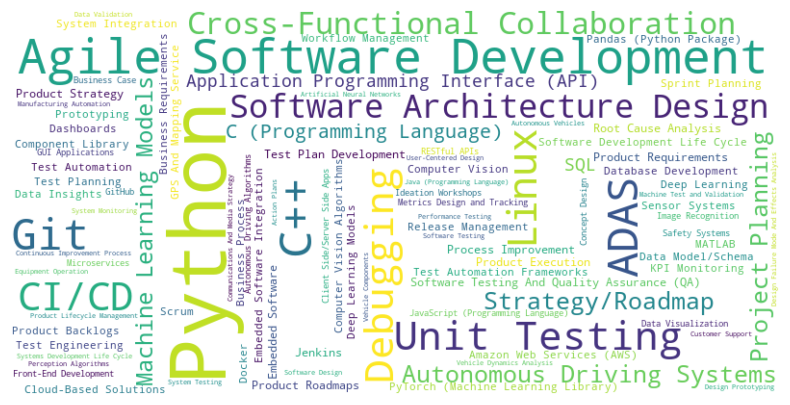

In [458]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Step 1: 计算每个 value 对应的 unique created_by 数量

filtered_concatenated_df['value'] = filtered_concatenated_df['value'].replace('Agile Methodology', 'Agile Software Development')
filtered_concatenated_df['value'] = filtered_concatenated_df['value'].replace('CI/CD Pipelines', 'CI/CD')
filtered_concatenated_df['value'] = filtered_concatenated_df['value'].replace('Advanced Driver Assistance Systems', 'ADAS')
value_unique_counts = filtered_concatenated_df.groupby('value')['created_by'].nunique().sort_values(ascending=False)
value_unique_counts = value_unique_counts.drop(['Software Development'], errors='ignore')


# Step 2: 选出前 N 个 value，可以选择 20 或 其他合适数量
top_values = value_unique_counts.head(100)

# Step 3: 创建词云，词的大小根据 unique created_by 的数量
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_values)

# Step 4: 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()

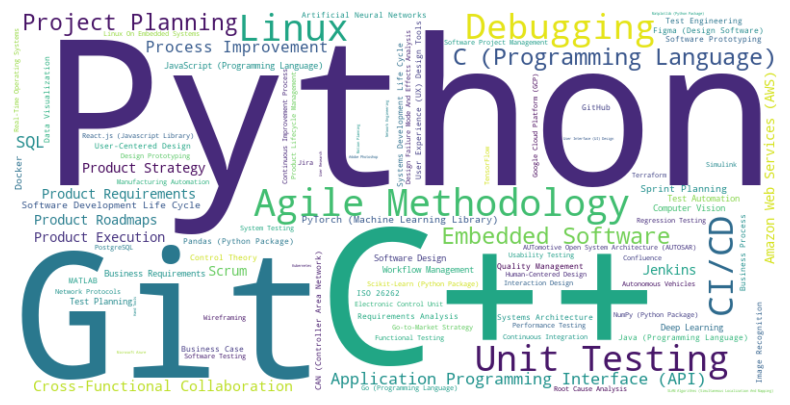

In [333]:

value_unique_counts = skill_1.groupby('skill')['created_by'].nunique().sort_values(ascending=False)
value_unique_counts = value_unique_counts.drop(['Software Development', 'Advanced Driver Assistance Systems'], errors='ignore')


# Step 2: 选出前 N 个 value，可以选择 20 或 其他合适数量
top_values = value_unique_counts.head(100)

# Step 3: 创建词云，词的大小根据 unique created_by 的数量
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_values)

# Step 4: 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()

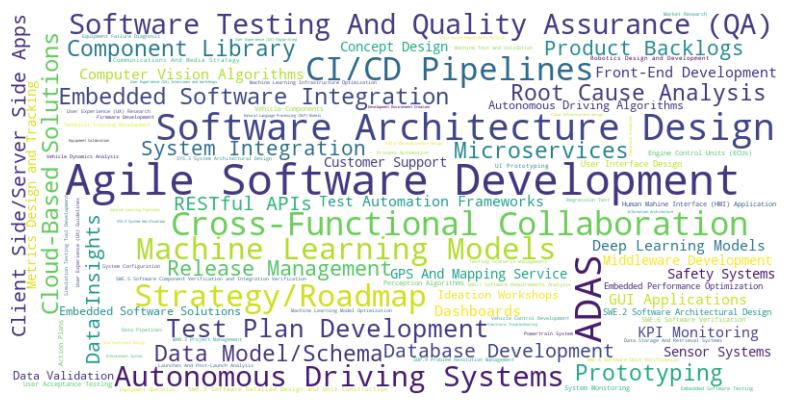

In [334]:
value_unique_counts = achievement_1.groupby('achievement')['created_by'].nunique().sort_values(ascending=False)
value_unique_counts = value_unique_counts.drop(['Software Development', 'Advanced Driver Assistance Systems'], errors='ignore')


# Step 2: 选出前 N 个 value，可以选择 20 或 其他合适数量
top_values = value_unique_counts.head(100)

# Step 3: 创建词云，词的大小根据 unique created_by 的数量
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_values)

# Step 4: 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()

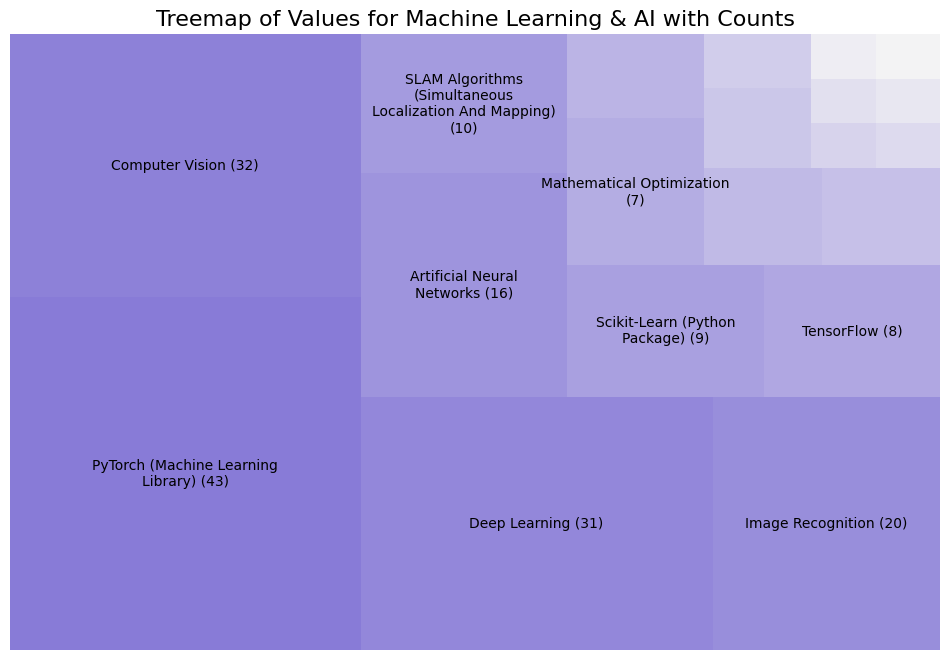

In [327]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
# Sample DataFrame (replace this with your actual DataFrame)
import squarify

# Sample DataFrame (replace this with your actual DataFrame)
# merged_df = pd.read_csv('path_to_your_data.csv')  # Load your DataFrame here
ml_list = ['AWS SageMaker',
'Predictive Modeling',
'Mathematical Optimization',
'Mathematical Modeling',
'Explainable AI (XAI)',
'Transfer Learning',
'Text Classification',
'Supervised Learning',
'Reinforcement Learning',
'Language Model',
'Qiskit',
'Natural Language Processing',
'SpaCy (NLP Software)',
'Generative Adversarial Networks',
'Time Series Analysis And Forecasting',
'TensorFlow',
'Scikit-Learn (Python Package)',
'Apache MXNet',
'SLAM Algorithms (Simultaneous Localization And Mapping)',
'Deep Learning',
'Computer Vision',
'Image Recognition',
'PyTorch (Machine Learning Library)',
'OpenCV',
'Keras (Neural Network Library)',
'Artificial Neural Networks',
'Semi-Supervised Learning',
'Random Forest Algorithm',
'Support Vector Machine',
'Image Processing',
'Audio Processing',
'Voice Recognition',
'Generative AI',
'Large Language Model',
'AutoML']
# Step 1: Filter the DataFrame
ml_df = filtered_concatenated_df[filtered_concatenated_df['value'].isin(ml_list)]
#ml_df.replace('Computer Vision Algorithms', 'Computer Vision', inplace=True)


# Step 2: Count the frequency of each unique value
value_counts = ml_df['value'].value_counts()

# Step 3: Prepare data for treemap
# Step 3: Prepare data for treemap
labels = [f'{val} ({count})' for val, count in zip(value_counts.index, value_counts.values)]  # Create labels with count
sizes = value_counts.values


#labels_with_threshold = [f'{label}' if size > 4 else '' for label, size in zip(labels, sizes)]
# Step 4: Plot the treemap
custom_palette = sns.light_palette("slateblue", len(labels),reverse=True)  # Dark blue-gray palette
#labels_with_threshold = [f'{label}' if size > 4 else '' for label, size in zip(labels, sizes)]
# Plot the treemap
def wrap_label(label, width=50):
    return "\n".join(textwrap.wrap(label, width=width))

threshold = 4  # Only show labels for squares larger than threshold
labels_wrapped = [wrap_label(label, width=25) if size > threshold else '' for label, size in zip(labels, sizes)]

#labels_with_threshold = [f'{label}' if size > 4 else '' for label, size in zip(labels, sizes)]
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels_wrapped, alpha=.8, color=custom_palette)
#labels_with_threshold = [f'{label}' if size > 4 else '' for label, size in zip(labels, sizes)]
plt.title('Treemap of Values for Machine Learning & AI with Counts', fontsize=16)
plt.axis('off')
plt.show()

In [449]:
market_ml_df = market_merged_df[market_merged_df['cate']=='Machine Learning & AI']
market_value_counts = market_ml_df['value'].value_counts()
simu_df = merged_df[merged_df['cate']=='Machine Learning & AI']
value_counts = simu_df['value'].value_counts()
market_value_counts_df = market_value_counts.reset_index()
market_value_counts_df.columns = ['value', 'market_ratio']

value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['value', 'simu_ratio']

# Perform a left join on the 'value' column
merged_counts_df = pd.merge(market_value_counts_df, value_counts_df, on='value', how='left')

# Fill NaN values in 'simu_count' with 0 if needed
merged_counts_df['simu_ratio'].fillna(0, inplace=True)

merged_counts_df['simu_ratio'] = merged_counts_df['simu_ratio']/504
merged_counts_df['market_ratio'] = merged_counts_df['market_ratio']/522

merged_counts_df['simu_ratio'] = (merged_counts_df['simu_ratio'] * 100).map('{:.2f}%'.format)
merged_counts_df['market_ratio'] = (merged_counts_df['market_ratio'] * 100).map('{:.2f}%'.format)
merged_counts_df.to_csv('ml_skill_comparison.csv')

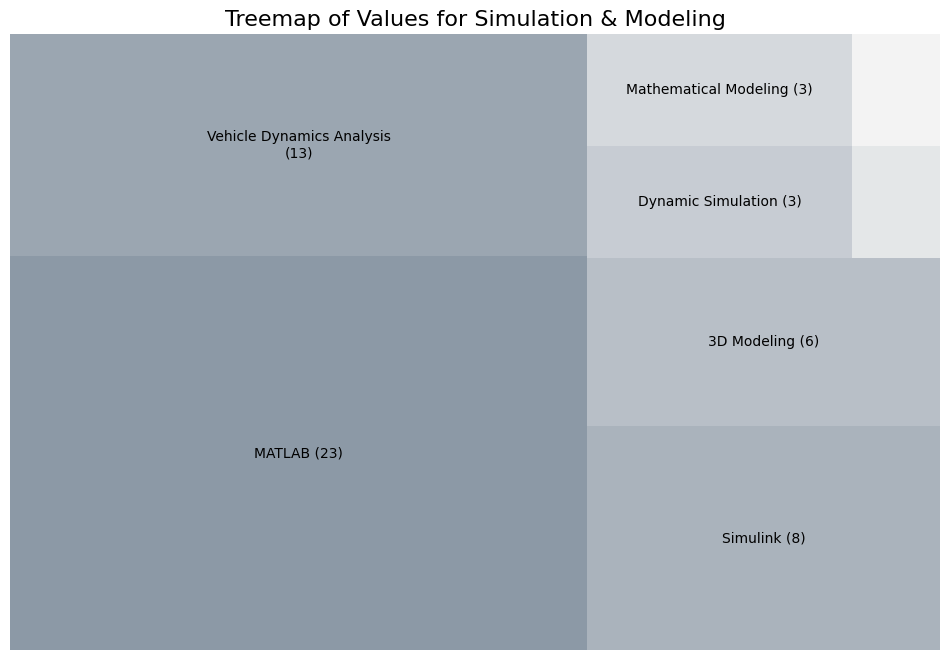

In [402]:
simu_df = merged_df[merged_df['cate']=='Simulation & Modeling']
#ml_df.replace('Computer Vision Algorithms', 'Computer Vision', inplace=True)


# Step 2: Count the frequency of each unique value
value_counts = simu_df['value'].value_counts()

# Step 3: Prepare data for treemap
# Step 3: Prepare data for treemap
labels = [f'{val} ({count})' for val, count in zip(value_counts.index, value_counts.values)]  # Create labels with count
sizes = value_counts.values

# Step 4: Plot the treemap
custom_palette = sns.light_palette("slategray", len(labels),reverse=True)  # Dark blue-gray palette

threshold = 1  # Only show labels for squares larger than threshold
labels_wrapped = [wrap_label(label, width=25) if size > threshold else '' for label, size in zip(labels, sizes)]

#labels_with_threshold = [f'{label}' if size > 4 else '' for label, size in zip(labels, sizes)]
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels_wrapped, alpha=.8, color=custom_palette)

# Plot the treemap


plt.title('Treemap of Values for Simulation & Modeling', fontsize=16)
plt.axis('off')
plt.show()

In [448]:
market_simu_df = market_merged_df[market_merged_df['cate']=='Simulation & Modeling']
market_value_counts = market_simu_df['value'].value_counts()
simu_df = merged_df[merged_df['cate']=='Simulation & Modeling']
value_counts = simu_df['value'].value_counts()
market_value_counts_df = market_value_counts.reset_index()
market_value_counts_df.columns = ['value', 'market_ratio']

value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['value', 'simu_ratio']

# Perform a left join on the 'value' column
merged_counts_df = pd.merge(market_value_counts_df, value_counts_df, on='value', how='left')

# Fill NaN values in 'simu_count' with 0 if needed
merged_counts_df['simu_ratio'].fillna(0, inplace=True)

merged_counts_df['simu_ratio'] = merged_counts_df['simu_ratio']/504
merged_counts_df['market_ratio'] = merged_counts_df['market_ratio']/522

merged_counts_df['simu_ratio'] = (merged_counts_df['simu_ratio'] * 100).map('{:.2f}%'.format)
merged_counts_df['market_ratio'] = (merged_counts_df['market_ratio'] * 100).map('{:.2f}%'.format)
merged_counts_df.to_csv('simu_skill_comparison.csv')

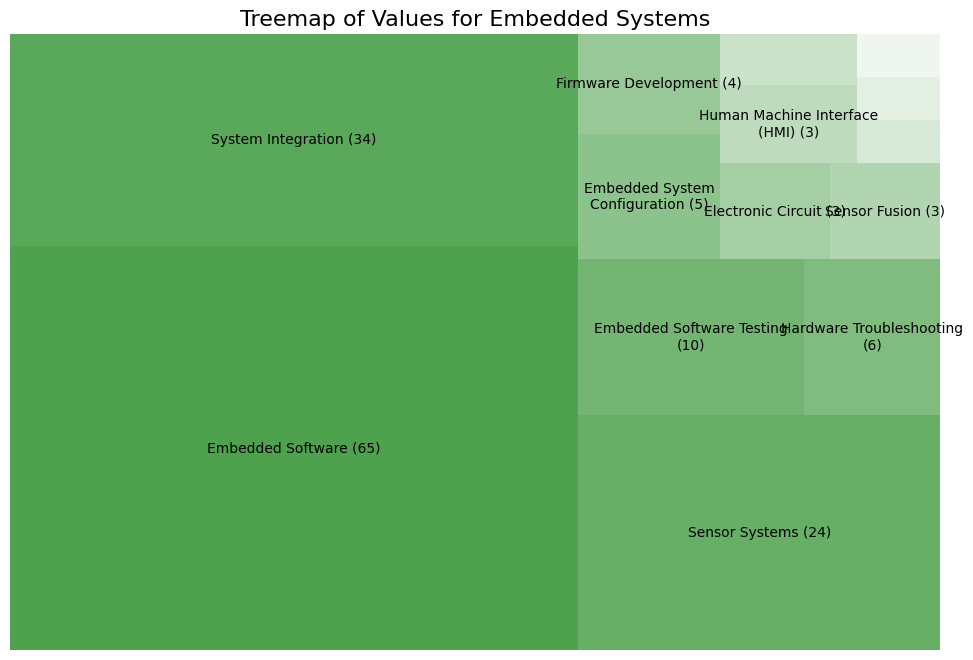

In [445]:
simu_df = merged_df[merged_df['cate']=='Embedded Systems']
#ml_df.replace('Computer Vision Algorithms', 'Computer Vision', inplace=True)


# Step 2: Count the frequency of each unique value
value_counts = simu_df['value'].value_counts()

# Step 3: Prepare data for treemap
# Step 3: Prepare data for treemap
labels = [f'{val} ({count})' for val, count in zip(value_counts.index, value_counts.values)]  # Create labels with count
sizes = value_counts.values


#labels_with_threshold = [f'{label}' if size > 4 else '' for label, size in zip(labels, sizes)]
# Step 4: Plot the treemap
custom_palette = sns.light_palette("forestgreen", len(labels),reverse=True)  # Dark blue-gray palette
#labels_with_threshold = [f'{label}' if size > 4 else '' for label, size in zip(labels, sizes)]
# Plot the treemap
def wrap_label(label, width=50):
    return "\n".join(textwrap.wrap(label, width=width))

threshold = 2  # Only show labels for squares larger than threshold
labels_wrapped = [wrap_label(label, width=25) if size > threshold else '' for label, size in zip(labels, sizes)]

#labels_with_threshold = [f'{label}' if size > 4 else '' for label, size in zip(labels, sizes)]
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels_wrapped, alpha=.8, color=custom_palette)
#labels_with_threshold = [f'{label}' if size > 4 else '' for label, size in zip(labels, sizes)]
plt.title('Treemap of Values for Embedded Systems', fontsize=16)
plt.axis('off')
plt.show()

In [447]:
market_simu_df = market_merged_df[market_merged_df['cate']=='Embedded Systems']
market_value_counts = market_simu_df['value'].value_counts()
simu_df = merged_df[merged_df['cate']=='Embedded Systems']
value_counts = simu_df['value'].value_counts()
market_value_counts_df = market_value_counts.reset_index()
market_value_counts_df.columns = ['value', 'market_ratio']

value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['value', 'simu_ratio']

# Perform a left join on the 'value' column
merged_counts_df = pd.merge(market_value_counts_df, value_counts_df, on='value', how='left')

# Fill NaN values in 'simu_count' with 0 if needed
merged_counts_df['simu_ratio'].fillna(0, inplace=True)

merged_counts_df['simu_ratio'] = merged_counts_df['simu_ratio']/504
merged_counts_df['market_ratio'] = merged_counts_df['market_ratio']/522

merged_counts_df['simu_ratio'] = (merged_counts_df['simu_ratio'] * 100).map('{:.2f}%'.format)
merged_counts_df['market_ratio'] = (merged_counts_df['market_ratio'] * 100).map('{:.2f}%'.format)
merged_counts_df.to_csv('embedded_skill_comparison.csv')

top 10 skills

most/least proficient skills

In [441]:
# 计算每个 value 的唯一 created_by 数量，并按降序排列
skill_filtered = skill_1[skill_1['created_by'].isin(filtered_role['created_by'])]

value_counts = skill_filtered.groupby('skill')['created_by'].nunique().sort_values(ascending=False)

# 筛选出前 100 个 value
top_100_values = value_counts.head(100).index

# 在 skill_1 中过滤出这前 100 个 value
filtered_skill_1 = skill_1[skill_1['skill'].isin(top_100_values)]

# Step 1: Group by 'skill' and count occurrences
skill_counts = filtered_skill_1['skill'].value_counts()

# Step 2: Filter to keep only the skills with a count >= 5
skills_to_keep = skill_counts[skill_counts >= 5].index

# Step 3: Filter 'filtered_skill_1' again to keep only these skills
filtered_skill_1 = filtered_skill_1[filtered_skill_1['skill'].isin(skills_to_keep)]

# 计算每个 value 的 skill_level 平均值和计数
skill_stats = filtered_skill_1.groupby('skill').agg(
    avg_skill_level=('skill_level', 'mean'),  # 计算平均 skill_level
    count=('skill_level', 'size')  # 计算出现次数
)

# 筛选出前 10 个平均 skill_level 最高的技能，同时显示计数
top_10_skills = skill_stats.sort_values(by='avg_skill_level', ascending=False).head(10)

# 输出结果
top_10_skills.to_csv('most_proficient_skills.csv')

In [442]:
last_10_skills = skill_stats.sort_values(by='avg_skill_level', ascending=True).head(10)

# 输出结果
last_10_skills.to_csv('least_proficient_skills.csv')

skill relevance analysis

In [450]:
concatenated_df_counts =  filtered_concatenated_df.groupby('value')['created_by'].nunique().sort_values(ascending=False)
concatenated_df_counts = concatenated_df_counts.drop(['Software Development', 'Advanced Driver Assistance Systems'], errors='ignore')
top_100_values = concatenated_df_counts.head(20).index

concatenated_df_100 = filtered_concatenated_df[filtered_concatenated_df['value'].isin(top_100_values)]


In [451]:
from itertools import combinations

# Group by 'created_by' and apply a list to collect all associated 'value' entries
created_by_groups = concatenated_df_100.groupby('created_by')['value'].apply(list)

# Initialize an empty dictionary to store edges and their weights (strength of correlation)
edges = {}

# Loop through each group of values associated with the same 'created_by'
for values in created_by_groups:
    # Remove duplicate values within each 'created_by' group
    unique_values = list(set(values))
    
    # Get all combinations of value pairs (after deduplication)
    for pair in combinations(unique_values, 2):
        # Sort pair so that (A, B) is the same as (B, A)
        pair = tuple(sorted(pair))
        
        # Increase the weight/count for this pair of values
        if pair in edges:
            edges[pair] += 1
        else:
            edges[pair] = 1

# Convert the edges dictionary into a DataFrame for easier manipulation (optional)
edges_df = pd.DataFrame(list(edges.items()), columns=['pair', 'weight'])


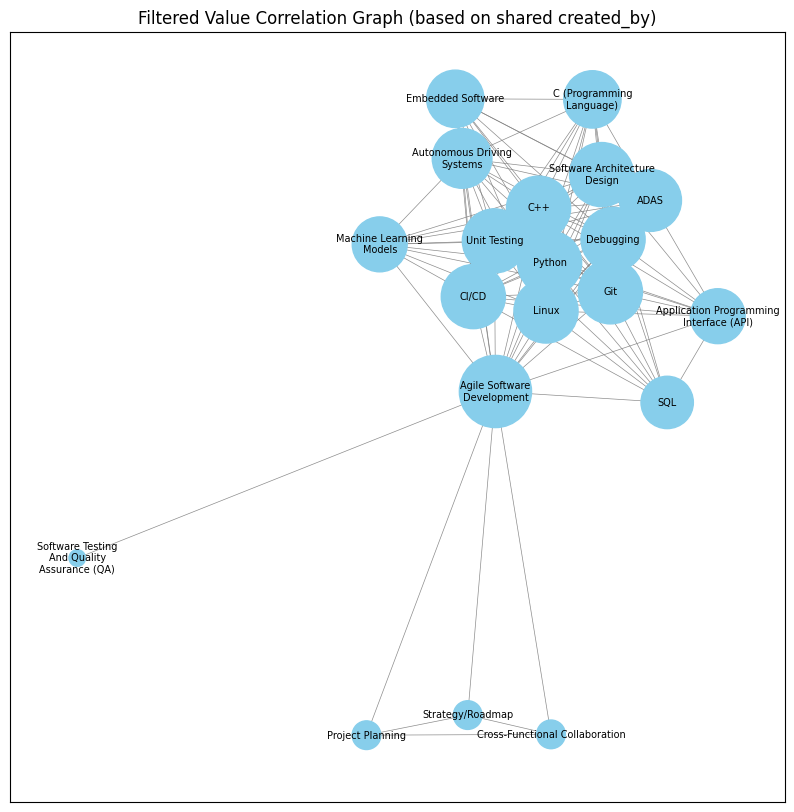

In [456]:
def wrap_text_by_space(text, max_words_per_line=2):
    words = text.split()  # Split the text into words
    wrapped_text = []
    
    # Group words into lines with a maximum number of words per line
    for i in range(0, len(words), max_words_per_line):
        wrapped_text.append(' '.join(words[i:i+max_words_per_line]))
    
    return '\n'.join(wrapped_text)

# Create a filtered version of the graph where only strong edges are kept
weight_threshold = 25
filtered_edges = [(u, v, w) for (u, v, w) in G.edges(data=True) if w['weight'] > weight_threshold]

# Create a new graph with only the filtered edges
G_filtered = nx.Graph()
G_filtered.add_edges_from(filtered_edges)

# Compute degree centrality for adjusting node size (can also use betweenness_centrality or closeness_centrality)
centrality = nx.degree_centrality(G_filtered)

# Draw the graph
plt.figure(figsize=(10, 10))

# Get edge weights for visualization (normalize for width)
edge_weights = [G_filtered[u][v]['weight'] / 20 for u, v in G_filtered.edges()]

# Set node size based on centrality, and increase the size for better visibility
node_sizes = [centrality[node] * 2700 for node in G_filtered.nodes()]  # Increased scaling factor

# Use a layout for node positions (try different layouts)
pos = nx.spring_layout(G_filtered)

# Wrap the node labels by space, limiting the number of words per line
wrapped_labels = {node: wrap_text_by_space(node, max_words_per_line=2) for node in G_filtered.nodes()}

# Draw nodes and edges, with edge thickness based on weight, dark blue edges, and larger nodes
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color="skyblue")
nx.draw_networkx_edges(G_filtered, pos, width=0.5, edge_color="gray", alpha=0.9)  # Dark blue edges
nx.draw_networkx_labels(G_filtered, pos, labels=wrapped_labels, font_size=7, font_color="black")

# Add a title and show the graph
plt.title('Filtered Value Correlation Graph (based on shared created_by)')
plt.show()

In [531]:
max_experience = achievement_1.groupby('created_by')['year_of_experiences'].max().reset_index()

# Step 2: Filter for max year_of_experiences >= 5
filtered_experience = max_experience[max_experience['year_of_experiences'] >= 5]

# Step 3: Get the unique list of 'created_by'
unique_created_by = filtered_experience['created_by'].unique()

In [546]:
filtered_df2 = filtered_concatenated_df[filtered_concatenated_df['created_by'].isin(unique_created_by)]

# Step 2: List of values to check for
target_values = [
    'Embedded System Configuration', 
    'Sensor Systems', 
    'Microcontrollers', 
    'Real-Time Control Firmwares', 
    'Process Failure Mode And Effects Analysis (PFMEA)', 
    'Design Failure Mode And Effects Analysis'
]

# Step 3: Filter rows where 'value' is in the target values
filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 3]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 0


In [544]:


# Step 2: List of values to check for
target_values = [
    'Dynamic Simulation', 
    'Signal Processing', 
    'Functional Safety Requirements', 
    'Process Simulation', 
    'Video Processing', 
    'Signal Processing Algorithms', 
    'Human Machine Interface (HMI)', 
    'Control Theory', 
    'Vehicle Dynamics Analysis', 
    'Image Processing', 
    'Perception Algorithms'
]

# Step 3: Filter rows where 'value' is in the target values
filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 3]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 2


In [543]:
target_values = [
    'Sensor Fusion', 
    'Vehicle Motion Management', 
    'Process Simulation', 
    'Motion Planning', 
    'Bayesian Statistics', 
    'Vehicle Dynamics Analysis', 
    'Motion Control Systems'
]
# Step 3: Filter rows where 'value' is in the target values
filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 2]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 1


In [552]:
target_values = [
    'Safety Systems', 
    'ISO 26262', 
    'Test Automation Frameworks', 
    'Performance Testing', 
    'Solution Architecture', 
    'Load Testing', 
    'Process Simulation', 
    'Simulation Testing Tool Development', 
    'Chassis Components', 
    'Functional Testing', 
    'High-performance computing (HPC) Applications'
]

# Step 3: Filter rows where 'value' is in the target values
filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 3]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 0


In [555]:
target_values = [
    'System Requirements Analysis (ASPICE SYS.2)', 
    'Software Requirements Analysis (ASPICE SWE.1)', 
    'Autonomous Driving Security', 
    'Circuit Breakers', 
    'Computer Aided Three-Dimensional Interactive Application (CATIA)', 
    'CAE Design Technology', 
    'Simulink', 
    'Software Testing And Quality Assurance (QA)', 
    'Test Plan Development'
]
# Step 3: Filter rows where 'value' is in the target values
filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 3]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 0


In [710]:

target_values = ['Requirements Analysis',
'3D Computer Graphics'
'V-Model'
'OpenGL'
'Sensor Systems'
'Security-Critical Application'
'Infotainment System'
'Rhapsody'
'Ray Tracing']

filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 3]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")



Number of 'created_by' with at least 4 covered values: 0


In [711]:
target_values =['MATLAB',
'Python',
'Mathematical Modeling',
'Machine Learning Models',
'Probability',
'AutoML',
'Image Processing']

filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 3]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")


Number of 'created_by' with at least 4 covered values: 7


In [714]:
target_values = [
    'Safety Systems',
    'Embedded System Configuration',
    'MATLAB',
    'Kaizen Methodology',
    'Radar',
    'CANoe',
    'Embedded Software Integration',
    'Sensor Systems',
    'Microcontrollers',
    'Engine Control Units (ECUs)',
    'Simulink',
    'Infotainment System',
    'Firmware',
    'Body Control'
]

filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 3]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 11


In [716]:
target_values = ['Functional Safety Requirements',
'MATLAB',
'Vehicle Dynamics Analysis']
filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 2]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 3


In [721]:
target_values = ['Safety Systems',
'Manufacturing Processes',
'Process Improvement',
'Performance Testing',
'Test Plan Development']
filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 3]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 3


In [723]:
target_values =['Data Visualization',
'Analytical Tools Development',
'Signal Processing',
'Machine Learning Models']

filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 2]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 5


In [726]:
target_values = ['Human-Centered Design',
'Geospatial Analysis',
'Spatial Data Infrastructures',
'Geographic Information Systems',
'Requirements Analysis',
'System Architectural Design (ASPICE SYS.3)']

filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 1]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")

Number of 'created_by' with at least 4 covered values: 14


In [733]:
target_values =['Sensor Systems',
'MATLAB',
'Simulink',
'Safety Systems',
'Embedded System Configuration',
'Control Theory',
'Radar',
'Requirements Analysis']

filtered_values_df = filtered_df2[filtered_df2['value'].isin(target_values)]

# Step 4: Group by 'created_by' and count the number of unique target values for each person
value_counts = filtered_values_df.groupby('created_by')['value'].nunique().reset_index()

# Step 5: Filter for those who have covered at least 4 values
sufficient_coverage = value_counts[value_counts['value'] >= 3]

# Step 6: Get the count of created_by who meet the criteria
count_created_by = sufficient_coverage['created_by'].nunique()

# Display the result
print(f"Number of 'created_by' with at least 4 covered values: {count_created_by}")


Number of 'created_by' with at least 4 covered values: 4


In [560]:
grouped = filtered_df.groupby('job_cate')

# Step 2: Define a function that performs the analysis on each group
def process_group(df):
    # Explode the 'education' column
    education_exploded = df.explode('education').reset_index(drop=True)
    
    # Normalize the nested JSON structure to flatten it into columns
    education_df = pd.json_normalize(education_exploded['education'])
    
    # Add the 'full_name' back to the normalized DataFrame
    education_df['full_name'] = education_exploded['full_name']
    
    # Convert 'end_date' to numeric, handling cases where it might be missing or None
    education_df['end_date'] = pd.to_numeric(education_df['end_date'], errors='coerce')
    
    # Sort by 'full_name' and 'end_date' to get the most recent entry per person
    education_df_sorted = education_df.sort_values(by=['full_name', 'end_date'], ascending=[True, False])
    
    # Drop duplicates keeping the most recent entry per person
    education_most_recent = education_df_sorted.drop_duplicates(subset=['full_name'], keep='first')
    
    # Select the relevant columns: 'degrees', 'school.name', and 'full_name'
    education_filtered = education_most_recent[['full_name', 'degrees', 'school.name']]
    
    return education_filtered

# Step 3: Apply the function to each group and concatenate the results
education_per_job_cate = grouped.apply(process_group).reset_index(drop=True)

# Display the result
print(education_per_job_cate)

           full_name                                       degrees  \
0       abdul baseer                                     [masters]   
1     abdul hoffmann                  [master of science, masters]   
2         adam alper              [bachelors, bachelor of science]   
3    aditya immaneni                                     [masters]   
4       adrian hesse                                            []   
..               ...                                           ...   
517          tony he  [master of business administration, masters]   
518      wenjun kang                                     [masters]   
519    yoon-dong lee                                            []   
520       yushi wang                                     [masters]   
521         önay can            [doctorates, doctor of philosophy]   

                                          school.name  
0                                  um - dearborn imse  
1                        federal university of 

In [561]:
def categorize_degree(degree):
    # Convert degree to lowercase for easier matching
    degree = str(degree).lower()
    
    if 'master' in degree:
        return 'master'
    elif 'bachelor' in degree:
        return 'bachelor'
    elif 'doctor' in degree or 'phd' in degree:
        return 'phd'
    else:
        return 'below undergrad'

# Apply the categorize_degree function to the 'degrees' column
education_per_job_cate['degree_category'] = education_per_job_cate['degrees'].apply(categorize_degree)

In [678]:
# Merge filtered_df with education_per_job_cate on 'full_name'
merged_df = filtered_df.merge(education_per_job_cate[['full_name', 'degree_category']], on='full_name', how='left')

# Calculate the percentage of each degree_category within each job_cate
degree_percentage_per_job_cate = merged_df.groupby(['job_cate', 'job_level2','degree_category']).size().groupby(level=2).apply(lambda x: x / float(x.sum())).reset_index(name='%_of_degrees')

# Display the result
print(degree_percentage_per_job_cate)


                   job_cate job_level2  degree_category  %_of_degrees
0   Embedded System related    General         bachelor      0.200000
1   Embedded System related    General  below undergrad      0.241071
2   Embedded System related    General           master      0.276978
3   Embedded System related    General              phd      0.187500
4   Embedded System related       L5-6         bachelor      0.180000
..                      ...        ...              ...           ...
62     Testing & Validation       L5-6           master      0.046763
63     Testing & Validation       L5-6              phd      0.031250
64     Testing & Validation       L7-8           master      0.003597
65     Testing & Validation         L9         bachelor      0.010000
66     Testing & Validation         L9           master      0.003597

[67 rows x 4 columns]


/var/folders/r1/_qq3kznd1r5ghs738k7_2xxm0000gq/T/ipykernel_44374/3150996640.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  degree_percentage_per_job_cate = merged_df.groupby(['job_cate', 'job_level2','degree_category']).size().groupby(level=2).apply(lambda x: x / float(x.sum())).reset_index(name='%_of_degrees')


In [680]:
# Merge filtered_df and education_per_job_cate on 'full_name'
merged_df = filtered_df.merge(education_per_job_cate[['full_name', 'degree_category']], on='full_name', how='left')

# Step 1: Calculate the count of each degree_category within each job_cate and job_level2
degree_count_per_job_cate = merged_df.groupby(['job_cate', 'job_level2', 'degree_category']).size().reset_index(name='degree_count')

# Step 2: Calculate the total count of all degrees for each job_cate and job_level2
total_count_per_job_cate = merged_df.groupby(['job_cate', 'job_level2']).size().reset_index(name='total_count')

# Step 3: Merge the two DataFrames to calculate the percentage
merged_counts = pd.merge(degree_count_per_job_cate, total_count_per_job_cate, on=['job_cate', 'job_level2'])

# Step 4: Calculate the percentage of each degree_category within job_cate and job_level2
merged_counts['%_of_degrees'] = (merged_counts['degree_count'] / merged_counts['total_count']) * 100

# Display the result
print(merged_counts)


                   job_cate job_level2  degree_category  degree_count  \
0   Embedded System related    General         bachelor            20   
1   Embedded System related    General  below undergrad            27   
2   Embedded System related    General           master            77   
3   Embedded System related    General              phd             6   
4   Embedded System related       L5-6         bachelor            18   
..                      ...        ...              ...           ...   
62     Testing & Validation       L5-6           master            13   
63     Testing & Validation       L5-6              phd             1   
64     Testing & Validation       L7-8           master             1   
65     Testing & Validation         L9         bachelor             1   
66     Testing & Validation         L9           master             1   

    total_count  %_of_degrees  
0           130     15.384615  
1           130     20.769231  
2           130     59.2307

In [683]:
merged_counts.to_csv('job_cate_edu.csv')

In [670]:
yoe_dist = filtered_df.groupby(['job_cate','job_level2'])['inferred_years_experience'].mean().reset_index()
yoe_dist.to_csv('job_cate_yoe.csv')

In [689]:
comapany_dist = filtered_df.groupby(['job_cate','job_level2','job_company_name'])['full_name'].nunique().reset_index()
print(comapany_dist)
comapany_dist.to_csv('company_dist.csv')

                   job_cate job_level2  job_company_name  full_name
0   Embedded System related    General            cariad         61
1   Embedded System related    General            cruise          4
2   Embedded System related    General  horizon robotics          4
3   Embedded System related    General          motional          8
4   Embedded System related    General             tesla         22
..                      ...        ...               ...        ...
80     Testing & Validation       L5-6             tesla         13
81     Testing & Validation       L5-6              zoox          1
82     Testing & Validation       L7-8          motional          1
83     Testing & Validation         L9            cariad          1
84     Testing & Validation         L9             tesla          1

[85 rows x 4 columns]


In [691]:
job_level_counts = filtered_df.groupby(['job_cate', 'job_level2']).size().reset_index(name='count')

# Step 2: Calculate the total number of people for each `job_cate`
total_people_per_job_cate = filtered_df.groupby('job_cate').size().reset_index(name='total_count')

# Step 3: Merge the count of `job_level` with the total number of people in each `job_cate`
merged_job_level = job_level_counts.merge(total_people_per_job_cate, on='job_cate')

# Step 4: Calculate the percentage of each `job_level` within each `job_cate`
merged_job_level['percentage'] = (merged_job_level['count'] / merged_job_level['total_count'])

# Final result: merged_job_level contains job_cate, job_level, counts, total people, and percentage
print(merged_job_level)

                             job_cate job_level2  count  total_count  \
0             Embedded System related    General    130          259   
1             Embedded System related       L5-6     99          259   
2             Embedded System related       L7-8     12          259   
3             Embedded System related         L9     18          259   
4       Function and concept engineer    General     10           16   
5       Function and concept engineer       L5-6      6           16   
6           General Software Engineer    General     78          112   
7           General Software Engineer       L5-6     29          112   
8           General Software Engineer         L9      5          112   
9   Machine Learning and Data related    General     14           24   
10  Machine Learning and Data related       L5-6      8           24   
11  Machine Learning and Data related         L9      2           24   
12                             Safety    General      6         

In [692]:
merged_job_level.to_csv('industry_job_level_dist.csv')

In [727]:
filtered_df.to_csv('filtered_engineers_with_level.csv')
